In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

***Task 1***
- using graph sata structure to represent part of the Piccadilly line.
- Edge label with the actual distances which is collected by using onine map services (Google Maps)

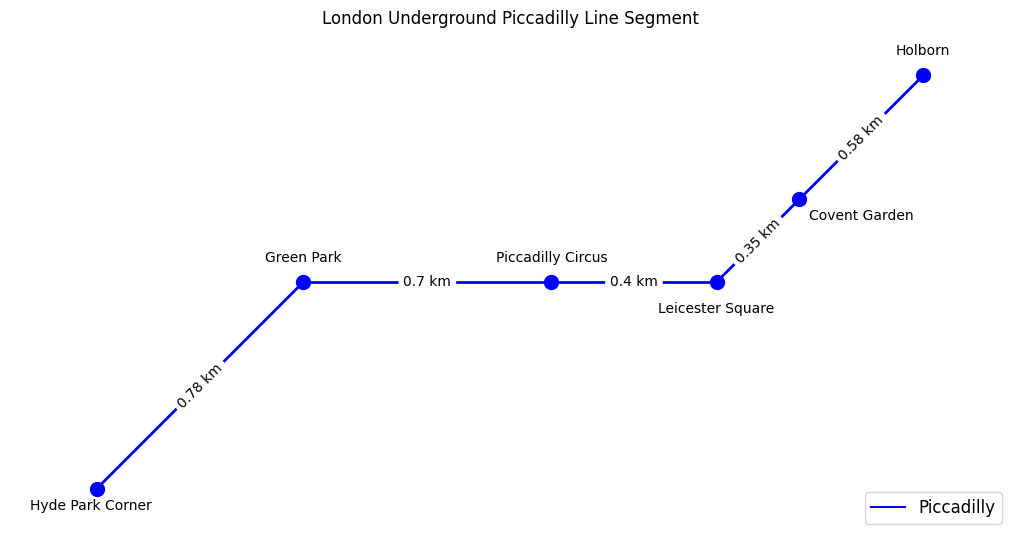

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Define graph data and manually set positions
stations = {
    'Hyde Park Corner': {'Green Park': 0.78},
    'Green Park': {'Piccadilly Circus': 0.7},
    'Piccadilly Circus': {'Leicester Square': 0.4},
    'Leicester Square': {'Covent Garden': 0.35},
    'Covent Garden': {'Holborn': 0.58}
}

# Positions of nodes on the graph
pos = {
    'Hyde Park Corner': (0, 0), 
    'Green Park': (1, 1), 
    'Piccadilly Circus': (2.2, 1),
    'Leicester Square': (3, 1), 
    'Covent Garden': (3.4, 1.4), 
    'Holborn': (4, 2)
}

# Manually define label positions for each station
label_positions = {
    'Hyde Park Corner': (-0.03, -0.1),
    'Green Park': (1, 1.1),
    'Piccadilly Circus': (2.2, 1.1),
    'Leicester Square': (3, 0.85),
    'Covent Garden': (3.7, 1.3),
    'Holborn': (4, 2.1)
}

fig = plt.figure(figsize=(10, 5))

# Create and draw graph
G = nx.Graph((station, connected, {"weight": dist})
             for station, connections in stations.items()
             for connected, dist in connections.items())

# Draw the graph
nx.draw(G, pos, with_labels=False, node_color='blue', node_size=100, edge_color='blue', width=2)

# Draw edge labels (distances)
edge_labels = {(u, v): f"{dist['weight']} km" for u, v, dist in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

# Add node labels manually
for station, (lx, ly) in label_positions.items():
    plt.text(lx, ly, station, fontsize=10, ha='center', color='black')

# Add legend and title
plt.plot([], [], color='blue', label='Piccadilly')
plt.legend(loc='lower right', fontsize=12)
plt.title("London Underground Piccadilly Line Segment")
plt.show()

# Save the figure
fig.savefig('Figure/Task1.png')


***Task2***

In [4]:
from math import sin, cos, sqrt, atan2, radians
def Haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Compute differences in coordinates
    dif_lon = lon2 - lon1
    dif_lat = lat2 - lat1

    # Apply Haversine formula
    a = sin(dif_lat / 2)**2 + cos(lat1) * cos(lat2) * sin(dif_lon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    # Radius of Earth in kilometers
    R = 6373.0
    return R * c

In [5]:
# Load the datasets
station_data = pd.read_csv('RawStationData/London_stations.csv')
line_data = pd.read_csv('RawStationData/London_tube_lines.csv')

# Keep only relevant columns in station_data
station_data = station_data[['Station', 'Latitude', 'Longitude']]

# Step 1:
# Merge the datasets based on station names
# Left merge to include only stations that are in both datasets
merged_data = line_data.merge(station_data, left_on='From Station', right_on='Station')
merged_data = merged_data.merge(station_data, left_on='To Station', right_on='Station', suffixes=('_From', '_To'))

# Define a function to calculate the distance between two stations
def calculate_distance(row):
    return round(Haversine(row['Latitude_From'], row['Longitude_From'], row['Latitude_To'], row['Longitude_To']), 2)

# Add a new column for distance
merged_data['Distance (km)'] = merged_data.apply(calculate_distance, axis=1)

# Drop unnecessary 'Station_From' and 'Station_To' columns
merged_data = merged_data.drop(columns=['Station_From', 'Station_To'])
# Step 3: Filter the dataset for selected tube lines
selected_lines = ["Bakerloo","Central", "Jubilee", "Circle", "District",
                  "Hammersmith and City", "Metropolitan", "Northern",
                    "Piccadilly", "Victoria", "Waterloo and City"]
filtered_data = merged_data[merged_data['Tube Line'].isin(selected_lines)]

# Step 4: Save the filtered dataset to a CSV file
filtered_dataset_filename = "StationData/selected_tube_lines.csv"
filtered_data.to_csv(filtered_dataset_filename, index=False)
print(f"Filtered dataset saved to '{filtered_dataset_filename}'")

Filtered dataset saved to 'StationData/selected_tube_lines.csv'


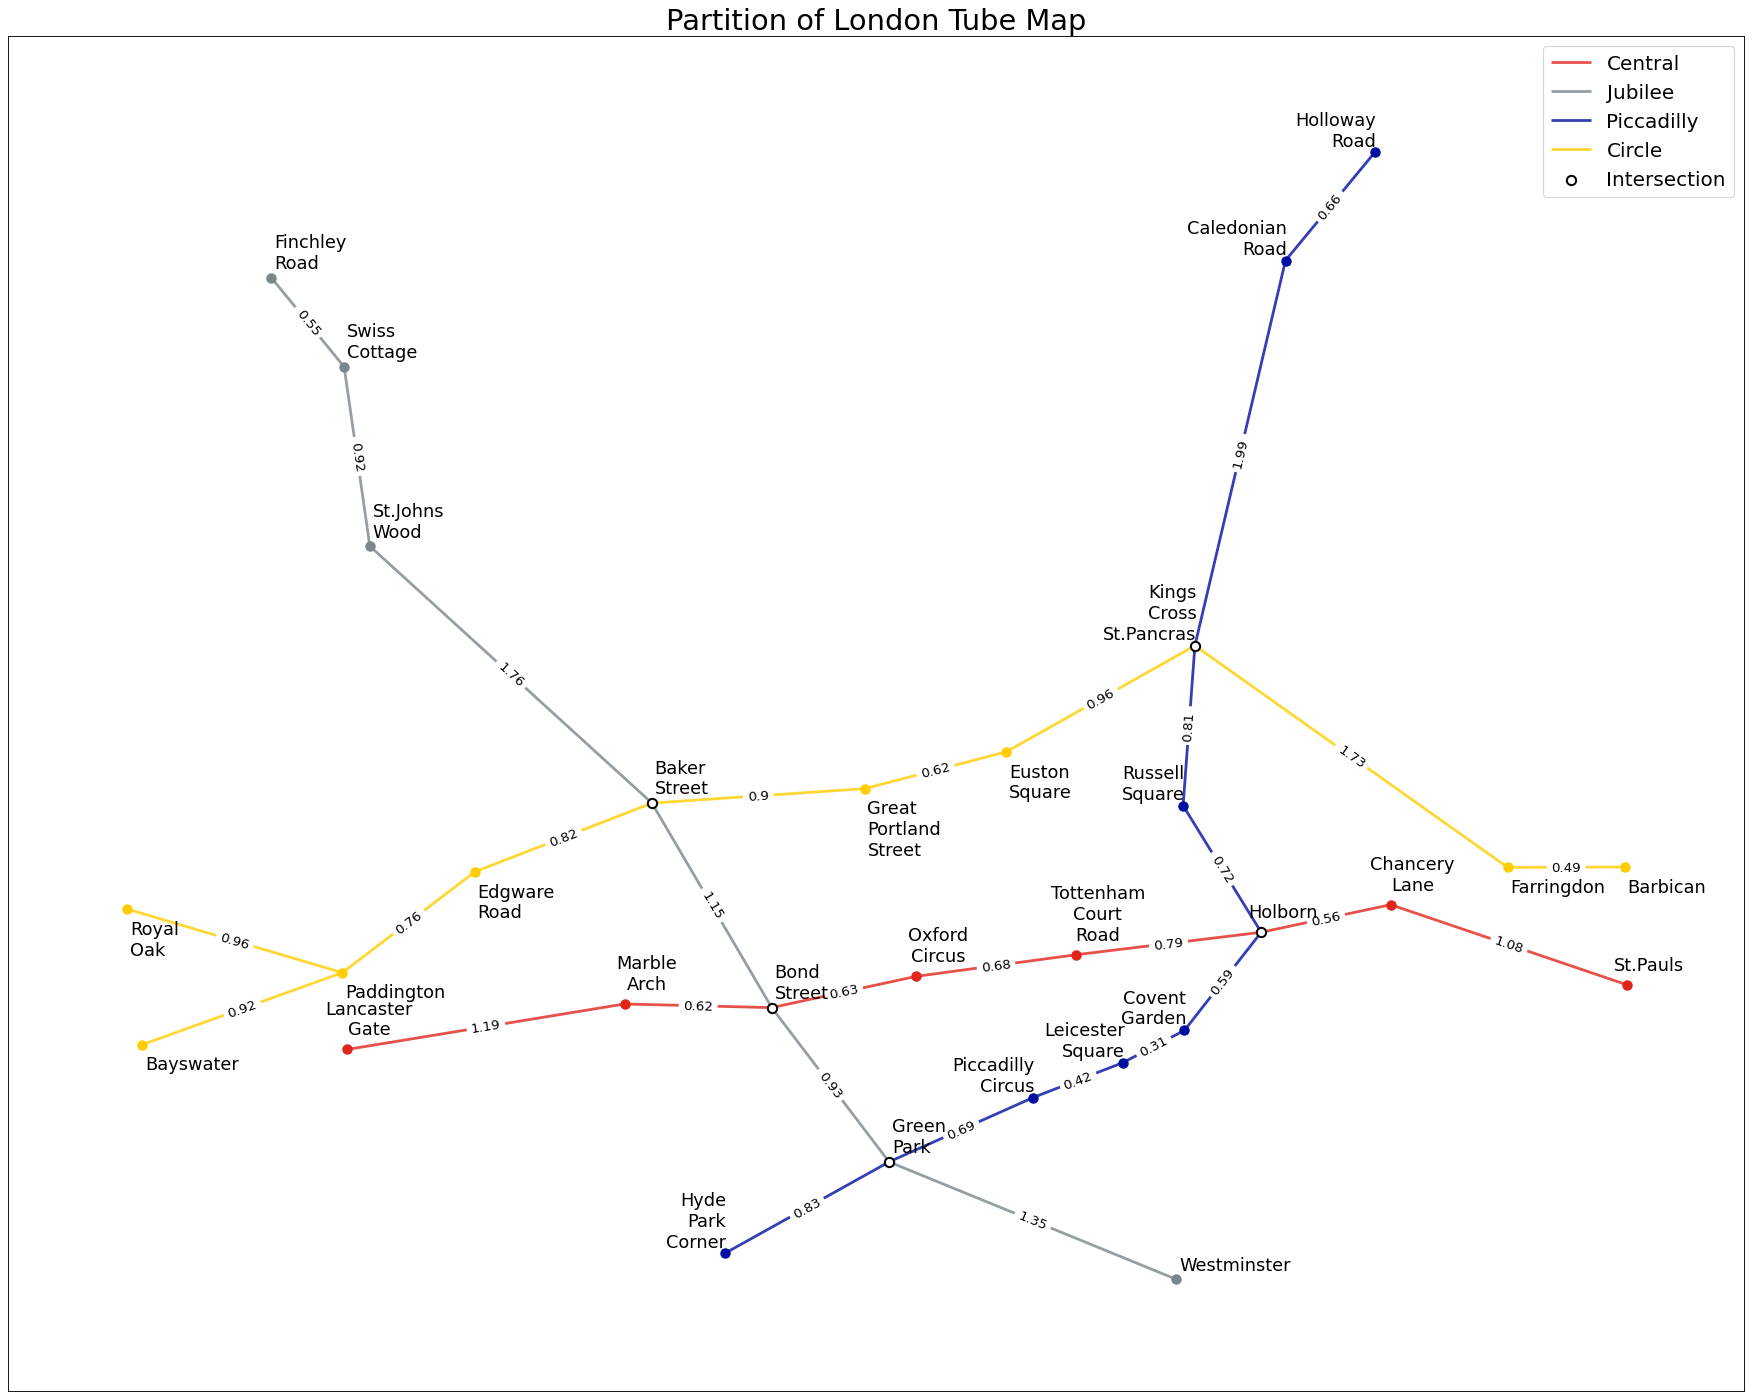

In [8]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

def split_label(text):
    words = text.split()
    if len(words) >= 2:
        return '\n'.join(words)
    else:
        return text

class TubeMap:
    def __init__(self, data_file, line_colors):
        self.data_file = data_file
        self.line_colors = line_colors
        self.G = nx.Graph()
        self.pos = {}

    def load_data(self):
        """ Load the tube line data from a CSV file into the graph. """
        data = pd.read_csv(self.data_file)
        
        for _, row in data.iterrows():
            # Add nodes with positions and line color
            self.G.add_node(row['From Station'], pos=(row['Longitude_From'], row['Latitude_From']), line=row['Tube Line'])
            self.G.add_node(row['To Station'], pos=(row['Longitude_To'], row['Latitude_To']), line=row['Tube Line'])
            
            # Add edges with distance and line information
            self.G.add_edge(
                row['From Station'], 
                row['To Station'], 
                weight=row['Distance (km)'], 
                line=row['Tube Line']
            )
        # Extract positions for plotting
        self.pos = nx.get_node_attributes(self.G, 'pos')
    def plot_map(self, scale_factor=(5, 5), line_settings=None):
        """ Plot the tube map with nodes, edges, and central labels for each line. """
        if line_settings is None:
            line_settings = {}

        # Scale positions independently for x and y axis
        scaled_pos = {station: (lon * scale_factor[0], lat * scale_factor[1]) for station, (lon, lat) in self.pos.items()}

        # Draw edges with line colors
        for line, color in self.line_colors.items():
            edges = [(u, v) for u, v, d in self.G.edges(data=True) if d['line'] == line]
            nx.draw_networkx_edges(self.G, scaled_pos, edgelist=edges, edge_color=color, width=2.5, alpha=0.8, label=line)

        # Identify intersection nodes that are part of multiple lines
        intersection_nodes = [
            node for node in self.G.nodes 
            if len({self.G.edges[edge]['line'] for edge in self.G.edges(node)}) > 1]
    
        # Draw regular nodes
        for line, color in self.line_colors.items():
            nodes = [node for node, data in self.G.nodes(data=True) if data['line'] == line and node not in intersection_nodes]
            nx.draw_networkx_nodes(self.G, scaled_pos, nodelist=nodes, node_color=color, node_size=70)
    
        # Draw intersection nodes with a black border and white fill
        nx.draw_networkx_nodes(self.G, scaled_pos, nodelist=intersection_nodes, node_color='white', edgecolors='black', node_size=70, linewidths=1.8)

        # Add edge labels for distances
        edge_labels = {(u, v): f"{dist['weight']}" for u, v, dist in self.G.edges(data=True)}
        nx.draw_networkx_edge_labels(self.G, scaled_pos, edge_labels=edge_labels, font_size=12, font_color='black')

        plt.scatter([], [], color='white', edgecolor='black', label='Intersection', s=70, linewidth=1.8)
        
        self.add_labels(scaled_pos, line_settings)
        
    def add_labels(self, scaled_pos, line_settings):
        """Add labels to nodes with calculated offsets and angles based on line settings."""
        for station, (x, y) in scaled_pos.items():
            # Get line settings
            line = self.G.nodes[station]['line']
            line_config = line_settings.get(line, {"h_offset": 0, "v_offset": 0, "ha": 'left', "va": 'bottom'})
            h_offset, v_offset = line_config["h_offset"], line_config["v_offset"]
            ha, va = line_config["ha"], line_config["va"]

            # Calculate adjusted label position
            label_x, label_y = x + h_offset, y + v_offset

            # Prepare label text
            label = split_label(station)
            plt.text(label_x, label_y, label, fontsize=16, ha=ha, va=va, color='black')


line_colors = {
    "Central": "#e1251b", 
    "Jubilee": "#7b868c", 
    "Piccadilly": "#000f9f", 
    "Circle": "#ffcd00"
}

# Define specific settings for each line (adjust radius, angle offset, and direction to reduce overlaps)
line_settings = {
    "Central": {"ha": 'center', "va": 'bottom', "h_offset": 0.08, "v_offset": 0.04},
    "Jubilee": {"ha": 'left', "va": 'bottom', "h_offset": 0.01, "v_offset": 0.02},
    "Piccadilly": {"ha": 'right', "va": 'bottom', "h_offset": 0.006, "v_offset": 0.01},
    "Circle": {"ha": 'left', "va": 'top', "h_offset": 0.01, "v_offset": -0.04}
}

# Run the plotting code again with the updated settings
tube_map = TubeMap(data_file='StationData/Task2Data.csv', line_colors=line_colors)
tube_map.load_data()

fig, ax = plt.subplots(figsize=(28, 22), dpi=80)
tube_map.plot_map(scale_factor=(60, 80), line_settings=line_settings)  # Scale x and y independently for better spread

fig.savefig('Figure/Task2_Hong.png')
plt.title("Partition of London Tube Map", fontsize=26)
plt.axis('equal')  # Maintain aspect ratio
plt.legend(loc='best', fontsize=18)
fig.savefig('Figure/Task2_Hong.png')
plt.show()


### Task 3:
- Total length of the transport network
- The average distance between the stations
- The standard deviation of the distances between the stations


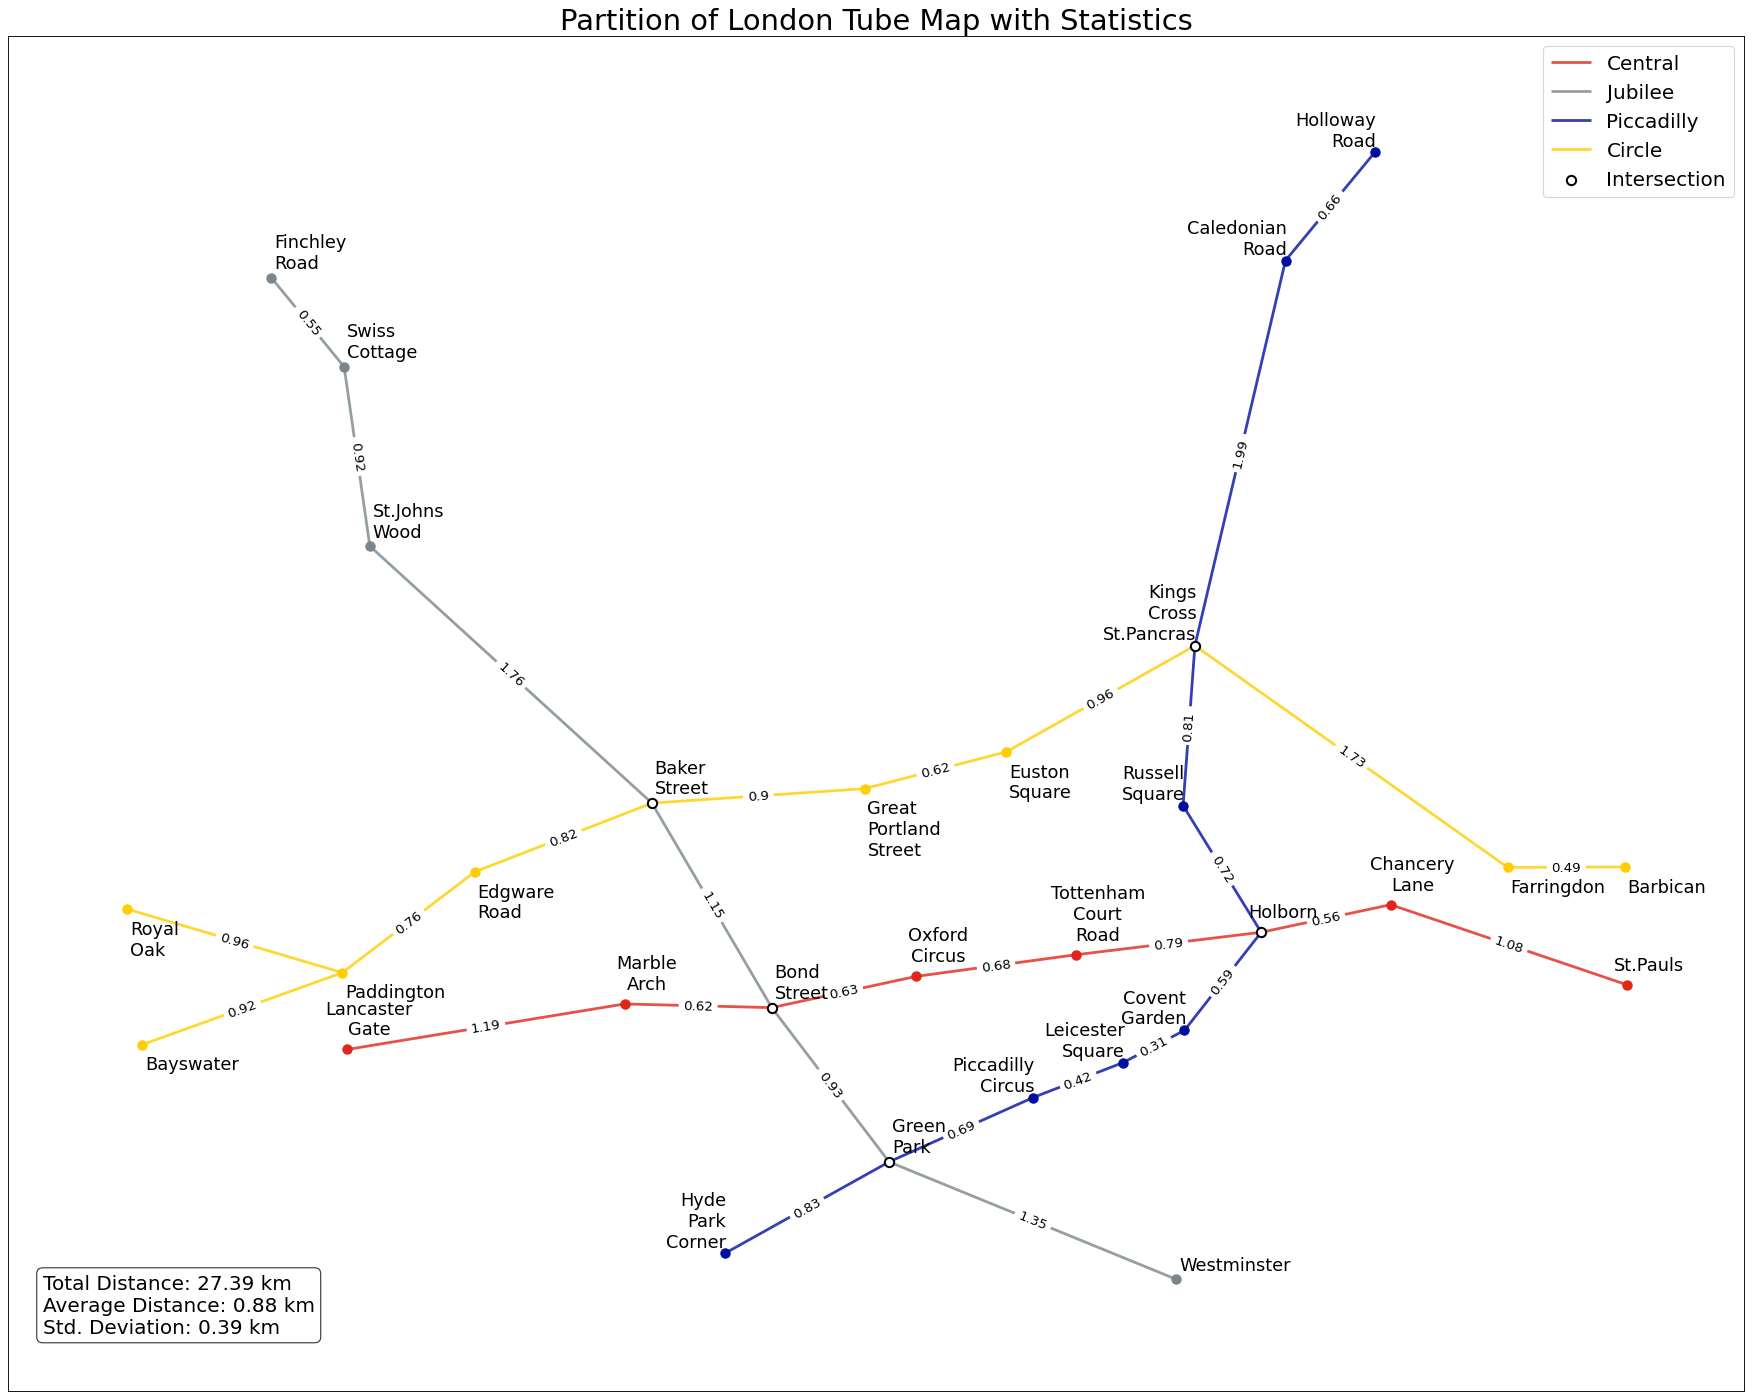

In [11]:
# Load tube data for statistical calculations
tube_df = pd.read_csv('StationData/Task2Data.csv')

# Calculate statistics
total_distance = tube_df['Distance (km)'].sum()
average_distance = round(tube_df['Distance (km)'].mean(), 2)
std_distance = round(tube_df['Distance (km)'].std(), 2)

# Prepare statistics text
stats_text = (f"Total Distance: {total_distance:.2f} km\n"
              f"Average Distance: {average_distance:.2f} km\n"
              f"Std. Deviation: {std_distance:.2f} km")

# Add statistics as a text box to the existing figure
fig, ax = plt.subplots(figsize=(28, 22), dpi=80)
tube_map.plot_map(scale_factor=(60, 80), line_settings=line_settings)  # Reuse existing map plotting logic

plt.text(0.02, 0.04, stats_text, transform=ax.transAxes, fontsize=18,
         verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Add title and save updated figure
plt.title("Partition of London Tube Map with Statistics", fontsize=26)
plt.axis('equal')  # Maintain aspect ratio
plt.legend(loc='best', fontsize=18)
fig.savefig('Figure/Task2_Hong3.png')
plt.show()

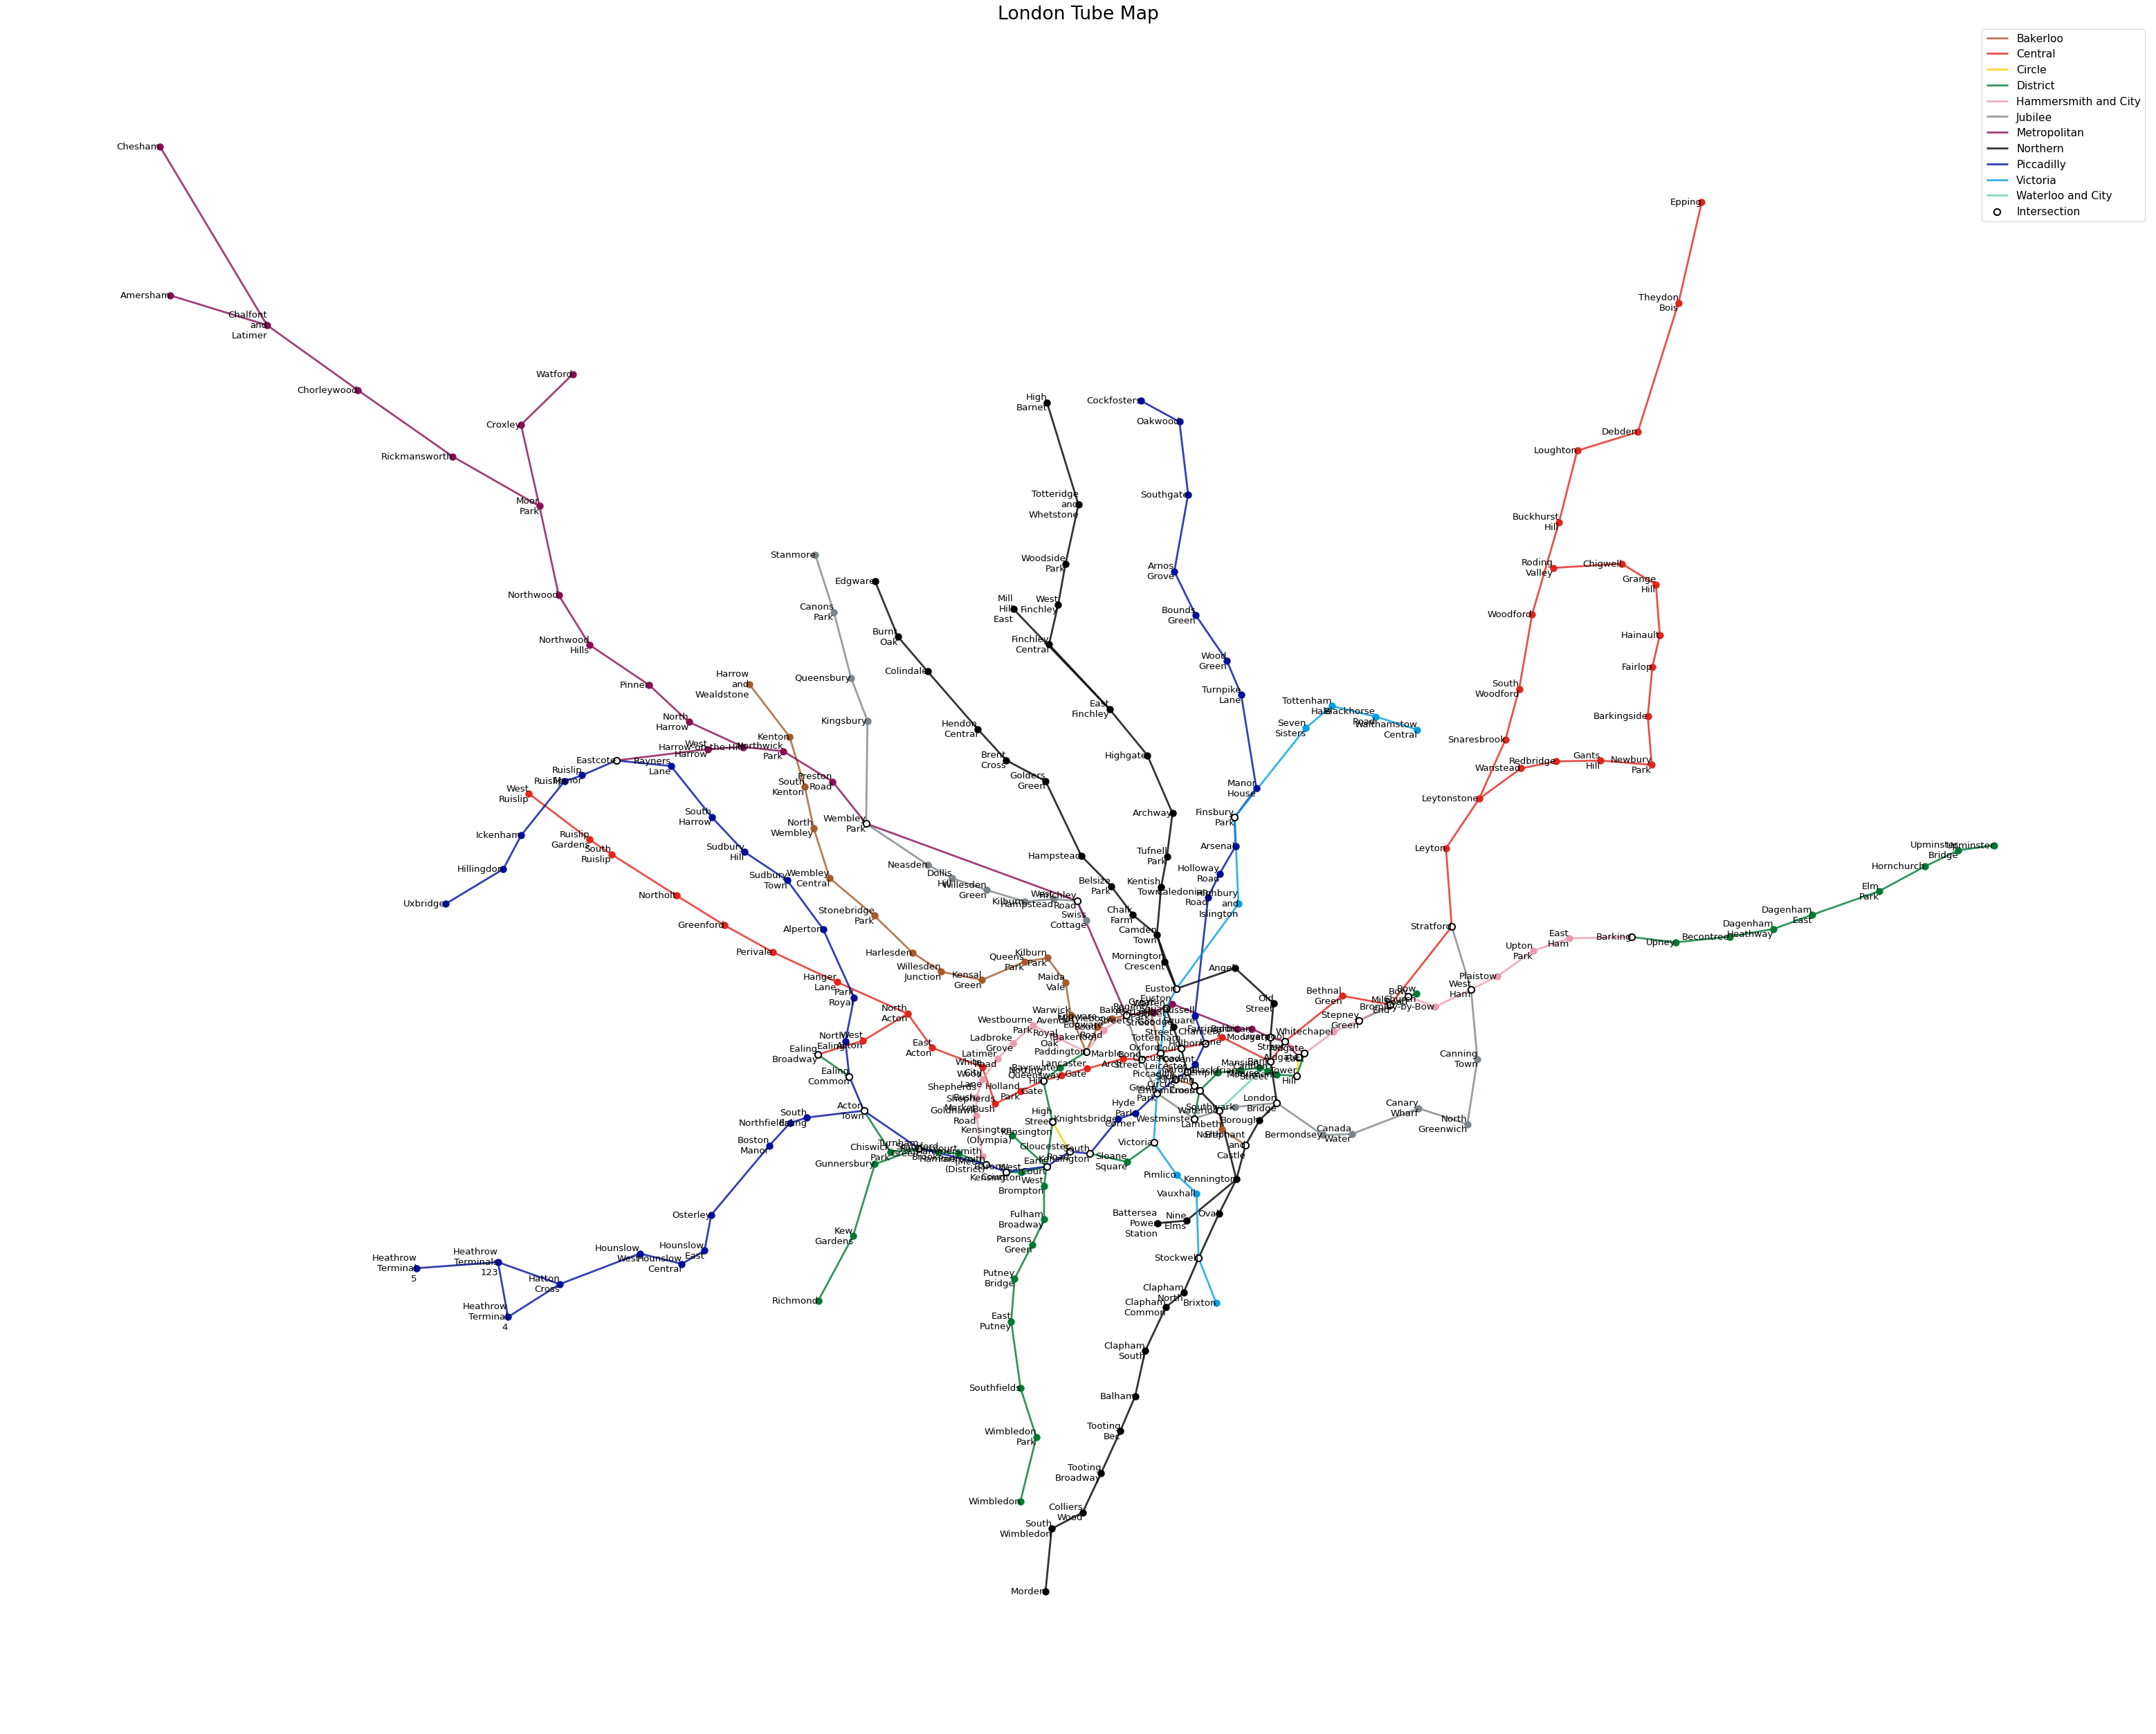

: 

: 

: 

: 

: 

: 

: 

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np

def split_label(text):
    words = text.split()
    if len(words) >= 2:
        return '\n'.join(words)
    else:
        return text

class TubeMap:
    def __init__(self, data_file, line_colors):
        self.data_file = data_file
        self.line_colors = line_colors
        self.G = nx.Graph()
        self.pos = {}

    def load_data(self):
        """ Load the tube line data from a CSV file into the graph. """
        data = pd.read_csv(self.data_file)
        
        for _, row in data.iterrows():
            # Add nodes with positions and line color
            self.G.add_node(row['From Station'], pos=(row['Longitude_From'], row['Latitude_From']), line=row['Tube Line'])
            self.G.add_node(row['To Station'], pos=(row['Longitude_To'], row['Latitude_To']), line=row['Tube Line'])
            
            # Add edges with distance and line information
            self.G.add_edge(
                row['From Station'], 
                row['To Station'], 
                weight=row['Distance (km)'], 
                line=row['Tube Line']
            )
        # Extract positions for plotting
        self.pos = nx.get_node_attributes(self.G, 'pos')
    def plot_map(self, scale_factor=(5, 5), line_settings=None):
        """ Plot the tube map with nodes, edges, and central labels for each line. """
        if line_settings is None:
            line_settings = {}

        # Scale positions independently for x and y axis
        scaled_pos = {station: (lon * scale_factor[0], lat * scale_factor[1]) for station, (lon, lat) in self.pos.items()}

        # Draw edges with line colors
        for line, color in self.line_colors.items():
            edges = [(u, v) for u, v, d in self.G.edges(data=True) if d['line'] == line]
            nx.draw_networkx_edges(self.G, scaled_pos, edgelist=edges, edge_color=color, width=2.5, alpha=0.8, label=line)

        # Identify intersection nodes that are part of multiple lines
        intersection_nodes = [
            node for node in self.G.nodes 
            if len({self.G.edges[edge]['line'] for edge in self.G.edges(node)}) > 1
        ]
    
        # Draw regular nodes
        for line, color in self.line_colors.items():
            nodes = [node for node, data in self.G.nodes(data=True) if data['line'] == line and node not in intersection_nodes]
            nx.draw_networkx_nodes(self.G, scaled_pos, nodelist=nodes, node_color=color, node_size=70)
    
        # Draw intersection nodes with a black border and white fill
        nx.draw_networkx_nodes(self.G, scaled_pos, nodelist=intersection_nodes, node_color='white', edgecolors='black', node_size=70, linewidths=1.8)

        # # Add edge labels for distances
        # edge_labels = {(u, v): f"{dist['weight']}" for u, v, dist in self.G.edges(data=True)}
        # nx.draw_networkx_edge_labels(self.G, scaled_pos, edge_labels=edge_labels, font_size=12, font_color='black')

        plt.scatter([], [], color='white', edgecolor='black', label='Intersection', s=70, linewidth=1.8)
        
        self.add_labels(scaled_pos, line_settings)
        
    def add_labels(self, scaled_pos, line_settings):
        """Add labels to nodes with calculated offsets and angles based on line settings."""
        for station, (x, y) in scaled_pos.items():
            # Get line settings
            line = self.G.nodes[station]['line']
            line_config = line_settings.get(line, {"h_offset": 0, "v_offset": 0, "ha": 'left', "va": 'bottom'})
            h_offset, v_offset = line_config["h_offset"], line_config["v_offset"]
            ha, va = line_config["ha"], line_config["va"]

            # Calculate adjusted label position
            label_x, label_y = x + h_offset, y + v_offset

            # Prepare label text
            label = split_label(station)
            plt.text(label_x, label_y, label, fontsize=12, ha=ha, va=va, color='black')

# Define line colors and key stations
tube_line_colors = {
    'Bakerloo': '#a65a2a',
    'Central': '#e1251b',
    'Circle': '#ffcd00',
    'District': '#007934',
    'Hammersmith and City': '#ec9bad',
    'Jubilee': '#7b868c',
    'Metropolitan': '#870f54',
    'Northern': '#000000',
    'Piccadilly': '#000f9f',
    'Victoria': '#00a0df',
    'Waterloo and City': '#6bcdb2'
}

line_settings = {
    'Bakerloo': {"h_offset": 0.005, "v_offset": 0.005, "ha": 'right', "va": 'center'},
    'Central': {"h_offset": 0.005, "v_offset": 0.005, "ha": 'right', "va": 'center'},
    'Circle': {"h_offset": 0.005, "v_offset": 0.005, "ha": 'right', "va": 'center'},
    'District': {"h_offset": 0.005, "v_offset": 0.005, "ha": 'right', "va": 'center'},
    'Hammersmith and City': {"h_offset": 0.005, "v_offset": 0.005, "ha": 'right', "va": 'center'},
    'Jubilee': {"h_offset": 0.005, "v_offset": 0.005, "ha": 'right', "va": 'center'},
    'Metropolitan': {"h_offset": 0.005, "v_offset": 0.005, "ha": 'right', "va": 'center'},
    'Northern': {"h_offset": 0.005, "v_offset": 0.005, "ha": 'right', "va": 'center'},
    'Piccadilly': {"h_offset": 0.005, "v_offset": 0.005, "ha": 'right', "va": 'center'},
    'Victoria': {"h_offset": 0.005, "v_offset": 0.005, "ha": 'right', "va": 'center'},
    'Waterloo and City': {"h_offset": 0.005, "v_offset": 0.005, "ha": 'right', "va": 'center'},
}
# Create and plot the tube map
tube_map_ext = TubeMap(data_file='StationData/selected_tube_lines.csv', line_colors=tube_line_colors)
tube_map_ext.load_data()

fig, ax = plt.subplots(figsize=(50, 40), dpi=80)
tube_map_ext.plot_map(scale_factor=(200, 200), line_settings=line_settings)  # Adjust scaling factor for better layout

plt.title("London Tube Map", fontsize=24)
plt.axis('off')  # Hide axes for better visualization
plt.legend(loc='best', fontsize=14)
plt.show()
